In [15]:
from scipy.optimize import fsolve
import math 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

font = {'family': 'normal', 'weight': 'bold', 'size': '14'}

matplotlib.rc('font', **font)



''' This python notebook includes Virtual temperature correction for the MSE equations (Eq7 and Eq6). It also uses the fc minimum
function instead of defining a specific value. Heat capacity correction has been added.'''

def universal_func(So=2000, Fo=50, mm_dry = 0.028, assumption = 'WTG', p_guess=(250,250,200,200,200,20),RH1 =0.9, RH2 = 0.8, RH3 = 0.3,debug=False):
    g = 13.7 #m/s^2 #gravity
    Pc = 6e4
    Po = 1.01e5
    R_star = 8.3145
    k3 = 0.08 # relates the strength of convection to the cloud fraction
    #fc = 0
    def equations(p): 
        T1, T2, T3, T4, Fa, Fc = p 

        ### Constants
        #print('solving or calculating ...')
        es0 = 611.2
        M = 0.018
        To = 273.15
        mass_ratio = M/mm_dry

        sigma = 5.67e-8 #W /m^2 K^4  Stefan Boltzmann Constant
        
        H = ((R_star/mm_dry)*T2)/g #scale height
        
        Tc = 230 #Cloud emission temp
        Z_a = np.log(Po/Pc)*H #convection height
        Cpd = 1005.7 #J/kgK #heat capacity
        Cpv = 1996 #J/kgK #heat capacity
        L = 2.501e6 # J/kg #latent heat of vaporization
        
        #RH1 = 0.9 #Relative Humidity
        #RH2 = 0.8 
        #RH3 = 0.3
        
        es_1 = es0*pow(np.e, L/(R_star/M)*(1/To - 1/T1))
        ws_1 = mass_ratio*es_1/(Po - es_1) #saturated mixing ratio
        w_1 = RH1 * ws_1
        q1 = w_1/(1+w_1)
        q1_s = ws_1/(1+ws_1)

        es_2 = es0*pow(np.e, L/(R_star/M)*(1/To - 1/T2))
        ws_2 = mass_ratio*es_2/(Pc - es_2) #saturated mixing ratio
        w_2 = RH2 * ws_2
        q2 = w_2/(1+w_2)
        q2_s = ws_2/(1+ws_2)
        
        es_3 = es0*pow(np.e, L/(R_star/M)*(1/To - 1/T3))
        ws_3 = mass_ratio*es_3/(Pc - es_3) #saturated mixing ratio
        w_3 = RH3 * ws_3
        q3 = w_3/(1+w_3)
        '''
        es_1 = es0*pow(np.e, L/(R_star/M)*(1/To - 1/T1))
        w_1 = mass_ratio*es_1/(Po - es_1) #saturated mixing ratio
        q1_s = w_1/(1+w_1)

        es_2 = es0*pow(np.e, L/(R_star/M)*(1/To - 1/T2))
        w_2 = mass_ratio*es_2/(Pc - es_2) #saturated mixing ratio
        q2_s = w_2/(1+w_2)
        
        es_3 = es0*pow(np.e, L/(R_star/M)*(1/To - 1/T3))
        w_3 = mass_ratio*es_3/(Pc - es_3) #saturated mixing ratio
        q3_s = w_3/(1+w_3)

        q1 = RH1 * q1_s
        q2 = RH2 * q2_s #specific humidity
        q3 = RH3 * q3_s #specific humidity
        '''
        
        Cp1 = Cpd*(1 - q1) + Cpv * q1
        Cp2 = Cpd*(1 - q2) + Cpv * q2
        
        ''' Want to add the greenhouse effect.epsilon and tau.'''
        
        #q1 = RH_1 * q1_s #Need to change this relation to the exact definition
        #q2 = RH_2 * q2_s #specific humidity
        #q3 = RH_3 * q3_s #specific humidity

        #So = 2000 # W/m^2 Solar insolation
        #Fo' = 0 # Ocean heat transport

        
        k1 = 0.2 # Fraction of heat transport to the nightside deposited in the boundary layer
        k2 = 1000 # Relates water vapor to the infrared opacity 
        #k3 = 0.08 # relates the strength of convection to the cloud fraction
        Fd = k1*Fa
        
        fc = k3*np.log(Fc+1.0)
        
        alpha_p = 0.09+fc - 0.09*fc # planetary albedo
        
        def Tv(T,mass_ratio,w):
            Tv = T*((1 + (w/mass_ratio))/(1+w)) # w is the water vapor mixing ratio
            return Tv

        def tau(T,Tft):
            tau = 0.56 + 0.07*np.exp(5413*((1/Tft)-(1/T)))
            return tau
            
        #epsilon_2 = 1/(1+tau(T2,273))
        #epsilon_3 = 1/(1+tau(T3,273))
        epsilon_2 = 1 - np.exp(-k2*q2) #emissivity
        epsilon_3 = 1 - np.exp(-k2*q3)

        Eq2 = (1/2)*So*(1-alpha_p)-Fc - Fo + (1-fc)*epsilon_2*sigma*T2**4 + fc*sigma*Tc**4 - sigma*T1**4

        Eq3 = Fc - Fa + (1-fc)*epsilon_2*sigma*T1**4 + fc*sigma*T1**4 - 2*(1-fc)*epsilon_2*sigma*T2**4 - 2*fc*sigma*Tc**4

        Eq4 = Fa - Fd + epsilon_3*sigma*T4**4 - 2*epsilon_3*sigma*T3**4

        Eq5 = Fo + Fd + epsilon_3*sigma*T3**4 - sigma*T4**4
        
        Eq6_WTG = T2 - T3

        Eq6_WBG = Tv(T2,mass_ratio,(q2/(1-q2))) - Tv(T3,mass_ratio,(q3/(1-q3)))

        Eq7_WTG = Cp1*T1 + L*q1 - (Cp2*T2+L*q2_s + g*Z_a)
        Eq7_WBG = Cp1*Tv(T1,mass_ratio,(q1/(1-q1))) + L*q1 - (Cp2*Tv(T2,mass_ratio,(q2/(1-q2)))+L*q2_s + g*Z_a)
        
        OLR_day = fc*sigma*Tc**4 +(1 - epsilon_2)*(1-fc)*sigma*T1**4 + (1-fc)*epsilon_2*sigma*T2**4
        OLR_night = (1 - epsilon_3)*sigma*T4**4 + epsilon_3*sigma*T3**4
        
        Flux = epsilon_2*sigma*T2**4
        
        if assumption == 'WTG':                         
            Eq6 = Eq6_WTG
            Eq7 = Eq7_WTG                       
        elif assumption == 'WBG':
            Eq6  = Eq6_WBG
            Eq7 = Eq7_WBG
        if index==0:
            return (Eq2, Eq3, Eq4, Eq5, Eq6, Eq7)
        if index==1:
            return(q1,q2,q3,alpha_p,epsilon_2,epsilon_3,OLR_day, OLR_night,Flux)
        
    index=0
    (T1, T2, T3, T4, Fa, Fc), info, ier, msg = fsolve(equations,p_guess,full_output=True)
    if ier==1:
        print ('We have a solution: ', (T1, T2, T3, T4, Fa, Fc))
    #fc_2 = fc
    fc_2 = k3*np.log(Fc+1.0)
    if fc_2 >=1:
        print('cloud fraction: ',fc_2)
    index=1
    #print('Solved.')
    q1,q2,q3,alpha_p,epsilon_2,epsilon_3, OLR_day, OLR_night, Flux = equations((T1, T2, T3, T4, Fa, Fc))
    if debug==False:
        return (T1, T2, T3, T4, Fa, Fc, fc_2, q1,q2,q3,alpha_p,epsilon_2,epsilon_3,OLR_day,OLR_night)
    else:
        return (T1, T2, T3, T4, Fa, Fc, fc_2, q1,q2,q3,alpha_p,epsilon_2,epsilon_3,OLR_day,OLR_night,info,ier,msg)

In [16]:
#RH = np.linspace(0,1,100)
universal_func(assumption='WBG', RH3=0.01)


We have a solution:  (304.82334826854463, 288.68270660606464, 291.12205923163043, 233.02686679408956, 166.62553999076445, 255.93788425797328)


(304.82334826854463,
 288.68270660606464,
 291.12205923163043,
 233.02686679408956,
 166.62553999076445,
 255.93788425797328,
 0.44390674881503117,
 0.02802147622199816,
 0.0154424130718972,
 0.0002305660841835159,
 0.4939551414216784,
 0.9999998034625959,
 0.20591604312166933,
 289.4193185908763,
 216.6255401368171)

In [17]:
#so = np.linspace(1000,4500,100)
RH3 = np.linspace(0.1,0.8,100)
nele = len(RH3)
T1_arr_WTG, T2_arr_WTG, T3_arr_WTG, T4_arr_WTG, Fa_arr_WTG, Fc_arr_WTG, fc_arr_WTG = np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele)
q1_arr_WTG,q2_arr_WTG,q3_arr_WTG,alpha_p_arr_WTG,epsilon_2_arr_WTG,epsilon_3_arr_WTG, OLR_day_arr_WTG, OLR_night_arr_WTG = np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele)

initial_guess = (250,250,200,200,200,20)
for idx,s in enumerate(RH3):
    T1_arr_WTG[idx], T2_arr_WTG[idx], T3_arr_WTG[idx], T4_arr_WTG[idx], Fa_arr_WTG[idx], Fc_arr_WTG[idx], fc_arr_WTG[idx], \
    q1_arr_WTG[idx],q2_arr_WTG[idx],q3_arr_WTG[idx],alpha_p_arr_WTG[idx],epsilon_2_arr_WTG[idx],epsilon_3_arr_WTG[idx], OLR_day_arr_WTG[idx], OLR_night_arr_WTG[idx] = universal_func(RH3 = s, assumption  = 'WTG', p_guess = initial_guess)
    initial_guess = (T1_arr_WTG[idx], T2_arr_WTG[idx], T3_arr_WTG[idx], T4_arr_WTG[idx], Fa_arr_WTG[idx], Fc_arr_WTG[idx])
    #print(initial_guess)    
#print(np.where(1 <= epsilon_3_arr_WBG))
#print(epsilon_3_arr_WBG[50:52])

We have a solution:  (292.2532687668264, 271.1093416430243, 271.1093416430243, 250.9620026329645, 210.2208951685715, 275.2367942875092)
We have a solution:  (291.90499561496733, 270.6055154042337, 270.6055154042337, 251.590885960426, 211.2845816501384, 275.54869899971004)
We have a solution:  (291.583905239392, 270.1399005941477, 270.1399005941477, 252.18595980339808, 212.25307994765586, 275.80686607473785)
We have a solution:  (291.28654318478254, 269.70778661727394, 269.70778661727394, 252.75132299961066, 213.13872649609263, 276.01916502706035)
We have a solution:  (291.0100718891691, 269.30528380572844, 269.30528380572844, 253.2903860794836, 213.951706040954, 276.1921540732715)
We have a solution:  (290.7521335970174, 268.9291445980755, 268.9291445980755, 253.8060183108849, 214.70052093293515, 276.3313441899845)
We have a solution:  (290.5107490709879, 268.5766306404113, 268.5766306404113, 254.3006571443783, 215.3923381781051, 276.44139859910575)
We have a solution:  (290.2842415259

In [18]:
#so = np.linspace(1000,4500,100)
nele = len(RH3)
T1_arr_WBG, T2_arr_WBG, T3_arr_WBG, T4_arr_WBG, Fa_arr_WBG, Fc_arr_WBG, fc_arr_WBG = np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele)
q1_arr_WBG,q2_arr_WBG,q3_arr_WBG,alpha_p_arr_WBG,epsilon_2_arr_WBG,epsilon_3_arr_WBG, OLR_day_arr_WBG, OLR_night_arr_WBG = np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele),  np.zeros(nele), np.zeros(nele)

initial_guess = (250,250,200,200,200,20)
for idx,s in enumerate(RH3):
    T1_arr_WBG[idx], T2_arr_WBG[idx], T3_arr_WBG[idx], T4_arr_WBG[idx], Fa_arr_WBG[idx], Fc_arr_WBG[idx], fc_arr_WBG[idx], \
    q1_arr_WBG[idx],q2_arr_WBG[idx],q3_arr_WBG[idx],alpha_p_arr_WBG[idx],epsilon_2_arr_WBG[idx],epsilon_3_arr_WBG[idx], OLR_day_arr_WBG[idx], OLR_night_arr_WBG[idx] = universal_func(RH3 = s, assumption  = 'WBG', p_guess = initial_guess)
    initial_guess = (T1_arr_WBG[idx], T2_arr_WBG[idx], T3_arr_WBG[idx], T4_arr_WBG[idx], Fa_arr_WBG[idx], Fc_arr_WBG[idx])
    

We have a solution:  (291.4853005308579, 270.60512068220334, 271.17535318990736, 251.17108245137243, 210.90319257255894, 277.3605845960741)
We have a solution:  (291.1538379719582, 270.1231429135842, 270.66664190419135, 251.78434071146052, 211.90933422836238, 277.6187085489167)
We have a solution:  (290.8479282340198, 269.6772648716841, 270.1966361671486, 252.365324227512, 212.82635905007152, 277.82809231536976)
We have a solution:  (290.56437040693544, 269.26309895630004, 269.7605491225893, 252.91790472170456, 213.66570246906085, 277.9960342078004)
We have a solution:  (290.30052889118997, 268.8770141843048, 269.3544304293029, 253.44531054953993, 214.43682491287393, 278.1286080731451)
We have a solution:  (290.0542088812549, 268.51597271713666, 268.97498343696196, 253.95026255397755, 215.14763750461637, 278.23090854720726)
We have a solution:  (289.8235641746576, 268.17740816245856, 268.61942955374946, 254.43507571771042, 215.80481878538004, 278.30723789600154)
We have a solution:  (2

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


(4, 100)


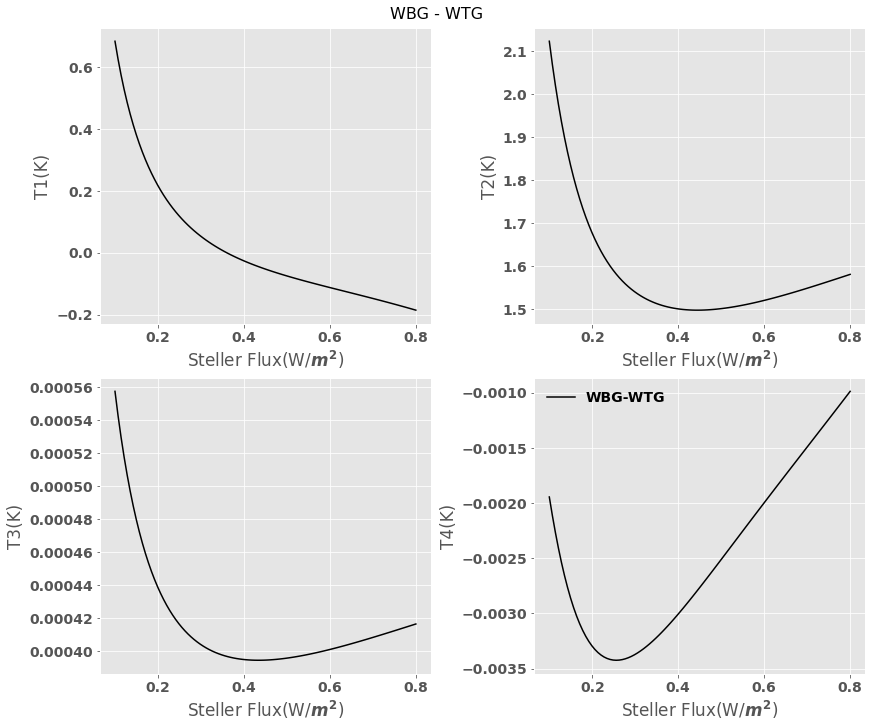

In [19]:
def plot_diff(RH3, xlab = 'Steller Flux', xunit = 'W/$m^2$'): 
    fig = plt.figure(figsize = (12,10))
    plt.suptitle('WBG - WTG', fontsize = 16)
    #arr_list_WBG = [q1_arr_WBG,q2_arr_WBG,q3_arr_WBG,fc_arr_WBG]
    #arr_list_WTG = [q1_arr_WTG,q2_arr_WTG,q3_arr_WTG,fc_arr_WTG]
    #arr_list_WBG = [T1_arr_WBG,T2_arr_WBG,T3_arr_WBG,T4_arr_WBG]
    #arr_list_WTG = [T1_arr_WTG,T2_arr_WTG,T3_arr_WTG,T4_arr_WTG]
    arr_list_WBG = [Fa_arr_WBG, Fc_arr_WBG, alpha_p_arr_WBG,epsilon_2_arr_WBG,epsilon_3_arr_WBG]
    arr_list_WTG = [Fa_arr_WTG, Fc_arr_WTG, alpha_p_arr_WTG,epsilon_2_arr_WTG,epsilon_3_arr_WTG]
    arr_list = [arr_list_WBG[idx] - arr_list_WTG[idx] for idx in range(4) ]

    nele = len(arr_list)
    #name_list = ['q1','q2','q3','fc']
    #unit_list = [r'$\frac{kg}{kg}$',r'$\frac{kg}{kg}$',r'$\frac{kg}{kg}$',r'$\frac{kg}{kg}$']
    name_list = ['T1','T2','T3','T4']
    unit_list = ['K','K','K','K']
    
    if nele % 2 == 0:
        nrows = (nele)//2
    else:
        nrows = (nele)//2+1, 
    ncols = 2
    print(np.shape(arr_list))

    for idx, arr in enumerate(arr_list):
        ax  =plt.subplot(nrows, ncols, idx + 1)

        ax.plot(RH3, arr, color = 'k', markersize = 9, label = 'WBG-WTG')
        #ax.set_title(assumption)
        ax.set_xlabel(xlab +'('+ xunit +')')
        ax.set_ylabel(name_list[idx]+'('+unit_list[idx]+')')
        #plt.xlim(1000,2400)
        #plt.ylim(160,320)
        if idx ==3: 
            plt.legend(frameon = False)
    plt.savefig("WTG_WBG_diff_T1-T4.png")
    plt.close()

    return fig
plot_diff(RH3)

(4, 100)
(4, 100)


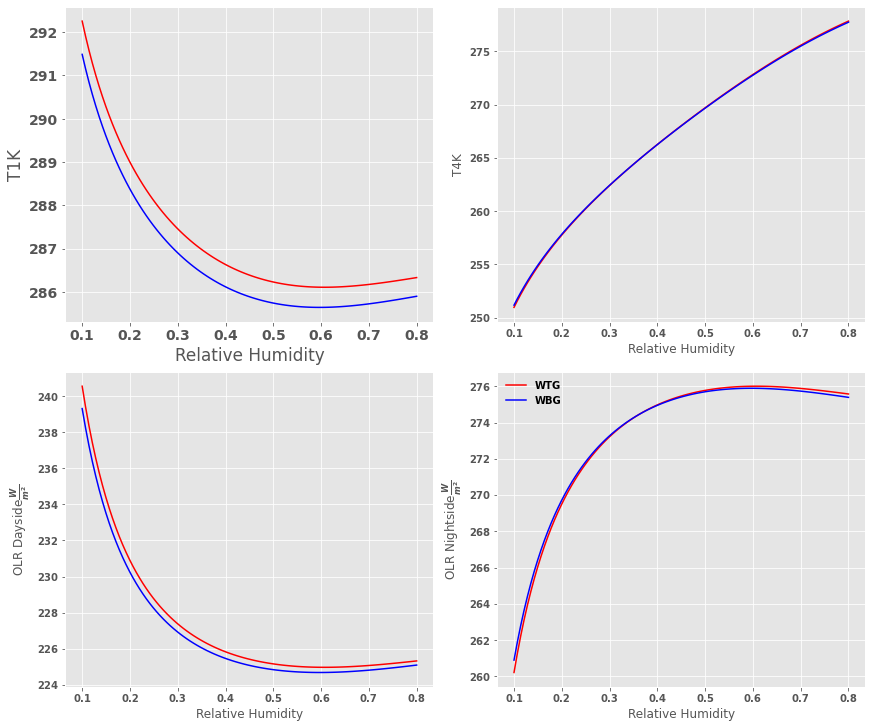

In [20]:
def plot_across_so(RH3, xlab = 'Relative Humidity', xunit = ''): 
    fig = plt.figure(figsize = (12,10))
    for i_assump, (assumption, my_color) in enumerate(zip(['WTG','WBG'], ['r','b'])):
        if assumption == 'WBG':
            #arr_list = [q1_arr_WBG,q2_arr_WBG,q3_arr_WBG,fc_arr_WBG]
            #arr_list = [T1_arr_WBG,T2_arr_WBG,T3_arr_WBG,T4_arr_WBG]
            #arr_list = [Fa_arr_WBG, Fc_arr_WBG, alpha_p_arr_WBG,epsilon_2_arr_WBG,epsilon_3_arr_WBG,fc_arr_WBG ]
            arr_list = [T1_arr_WBG, T4_arr_WBG, OLR_day_arr_WBG, OLR_night_arr_WBG]
        elif assumption == 'WTG':
            #arr_list = [q1_arr_WTG,q2_arr_WTG,q3_arr_WTG,fc_arr_WTG]
            #arr_list = [T1_arr_WTG,T2_arr_WTG,T3_arr_WTG,T4_arr_WTG]
            #arr_list = [Fa_arr_WTG, Fc_arr_WTG, alpha_p_arr_WTG,epsilon_2_arr_WTG,epsilon_3_arr_WTG,fc_arr_WTG]
            arr_list = [T1_arr_WTG, T4_arr_WTG, OLR_day_arr_WTG, OLR_night_arr_WTG]

        
        nele = len(arr_list)
        #name_list = ['T1','T2','T3','T4']
        #unit_list = ['K','K','K','K']
        #name_list = ['q1','q2','q3','fc']
        #unit_list = [r'$\frac{kg}{kg}$',r'$\frac{kg}{kg}$',r'$\frac{kg}{kg}$',r'$\frac{kg}{kg}$']
        #name_list = ['Fa','Fc',r'$\alpha_p$',r'$\epsilon_2$',r'$\epsilon_3$',r'$f_c$']
        #unit_list = [r'($\frac{W}{m^2}$)',r'($\frac{W}{m^2}$)','','', '','']
        name_list = ['T1','T4', 'OLR Dayside', 'OLR Nightside']
        unit_list = ['K', 'K', r'$\frac{W}{m^2}$',r'$\frac{W}{m^2}$']
        
        if nele % 2 == 0:
            nrows = (nele)//2
        else:
            nrows = (nele)//2+1
        ncols = 2
        print(np.shape(arr_list))

        for idx, arr in enumerate(arr_list):
            ax  =plt.subplot(nrows, ncols, idx + 1)

            ax.plot(RH3,arr, color = my_color, markersize = 9, label = assumption)
            plt.style.use('ggplot')

            #ax.set_title(assumption)
            ax.set_xlabel(xlab +xunit )
            ax.set_ylabel(name_list[idx]+unit_list[idx])
            #plt.xlim(1000,2400)
            #plt.ylim(160,320)
            if idx ==3: 
                plt.legend(frameon = False)
    

    plt.savefig("WTG_WBG_compare_T1-T4.png")
    plt.close()

    return fig

plt.rcParams['figure.constrained_layout.use']=True
plot_across_so(RH3)

### plotting

In [ ]:
def plot_8panels(RH3, xlab = 'Relative Humidity', xunit = ''): 
   
    
    
    #arr_list_WBG = [q1_arr_WBG,q2_arr_WBG,q3_arr_WBG,fc_arr_WBG]
    #arr_list_WTG = [q1_arr_WTG,q2_arr_WTG,q3_arr_WTG,fc_arr_WTG]
    arr_list_WBG = [T1_arr_WBG,T2_arr_WBG,T3_arr_WBG,T4_arr_WBG]
    arr_list_WTG = [T1_arr_WTG,T2_arr_WTG,T3_arr_WTG,T4_arr_WTG]
    #arr_list_WBG = [Fa_arr_WBG, Fc_arr_WBG, alpha_p_arr_WBG,epsilon_2_arr_WBG,epsilon_3_arr_WBG]
    #arr_list_WTG = [Fa_arr_WTG, Fc_arr_WTG, alpha_p_arr_WTG,epsilon_2_arr_WTG,epsilon_3_arr_WTG]
    
    
    name_list = ['T1','T2','T3','T4']
    unit_list = ['K','K','K','K']
    #name_list = ['q1','q2','q3','fc']
    #unit_list = [r'$\frac{kg}{kg}$',r'$\frac{kg}{kg}$',r'$\frac{kg}{kg}$',r'$\frac{kg}{kg}$']
    #name_list = ['Fa','Fc',r'$\alpha_p$',r'$\epsilon_2$',r'$\epsilon_3$']
    #unit_list = [r'$\frac{W}{m^2}$',r'$\frac{W}{m^2}$','','', '']
    nele = len(name_list)
    ncols = 2
    nrows = nele
    fig, axs = plt.subplots(nrows, ncols, sharex = True, figsize = (10,12))
    ax = axs[0][0]
    #nele = len(arr_list)
    #name_list = ['T1','T2','T3','T4']
    #unit_list = ['K','K','K','K']

    
    for i_assump, (assumption, my_color) in enumerate(zip(['WTG','WBG'], ['r','b'])):
        if assumption == 'WBG':
            arr_list = arr_list_WBG
        elif assumption == 'WTG':
            arr_list = arr_list_WTG


        
        print(np.shape(arr_list))

        for idx, arr in enumerate(arr_list):
            ax = axs[idx][0]

            ax.plot(RH3, arr, color = my_color, markersize = 9, label = assumption)

            #ax.set_title(assumption)
            #ax.set_xlabel(xlab +'('+ xunit +')')
            ax.set_ylabel(name_list[idx]+unit_list[idx])
            #plt.xlim(1000,2400)
            #plt.ylim(160,320)
            if idx == nele - 1: 
                ax.legend(frameon = False)
                ax.set_xlabel(xlab + xunit)
    
    
    ### plot difference
    #plt.suptitle('WBG - WTG', fontsize = 16)

    
    arr_list = [arr_list_WBG[idx] - arr_list_WTG[idx] for idx in range(nele) ]

    for idx, arr in enumerate(arr_list):
        ax = axs[idx][1]
        ax.plot(RH3, arr, color = 'k', markersize = 9, label = 'WBG-WTG')
        #ax.set_title(assumption)
        
        #ax.set_ylabel(name_list[idx]+'('+unit_list[idx]+')')
        #plt.xlim(1000,2400)
        #plt.ylim(160,320)
        if idx == nele -1: 
            plt.legend(frameon = False)
            plt.xlabel(xlab + xunit )
    plt.savefig("WTG_WBG_q1-q3.png")
    plt.close()
    
    #fig, axs = plt.subplots(nrows, ncols, sharex = True, figsize = (10,12))
        
        
    

    return fig
plot_8panels(RH3)

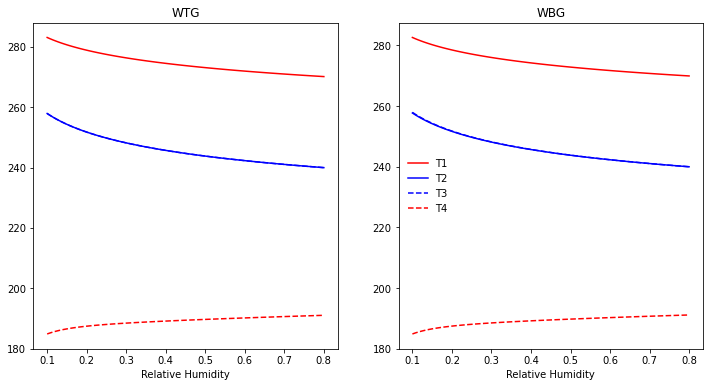

In [9]:
fig = plt.figure(figsize =(12,6))
plt.rcParams['savefig.facecolor']='white'

for i_assumption, assumption in enumerate(['WTG','WBG']): 
    ax = plt.subplot(1,2,1+i_assumption)
    ax.set_title(assumption)
    
    arr_list_WBG = [T1_arr_WBG,T2_arr_WBG,T3_arr_WBG,T4_arr_WBG]
    arr_list_WTG = [T1_arr_WTG,T2_arr_WTG,T3_arr_WTG,T4_arr_WTG]
    
    if assumption == 'WBG':
        arr_list = arr_list_WBG
        epsilon_arr = epsilon_2_arr_WBG
    elif assumption == 'WTG': 
        arr_list = arr_list_WTG
        epsilon_arr = epsilon_2_arr_WTG
    
    ax.plot(RH3, arr_list[0], color = 'r', linestyle = '-', label = 'T1')
    ax.plot(RH3, arr_list[1], color = 'b', linestyle = '-', label = 'T2')
    ax.plot(RH3, arr_list[2], color = 'b', linestyle = '--', label = 'T3')
    ax.plot(RH3, arr_list[3], color = 'r', linestyle = '--', label = 'T4')
    
    
    #transition_point = np.min(np.argwhere(1 <= epsilon_arr))
    #print(transition_point)
    #ax.scatter(so[transition_point], arr_list[0][transition_point], marker = '*', s = 60, color=  'k')
    
    #transition_point = np.min(np.argwhere(1 <= epsilon_arr))
    #print(transition_point)
    #ax.scatter(so[transition_point], arr_list[0][transition_point], marker = '*', s = 60, color=  'k', label = r'$\epsilon_2 = 1$')
    if i_assumption == 1:
        ax.legend(frameon = False)
    plt.xlabel('Relative Humidity' )
    plt.savefig('WTG_WBG_eps2.png', facecolor=fig.get_facecolor(), transparent=False)
